# INM707 Coursework Task 2
### Aaron Mir (Student Number: 160001207)

## Q-learning algorithm implemented for the Stronghold environment to find the best policy

***
## Stronghold

The robot agent is preparing for an upcoming mission in which they are to infiltrate an enemy stronghold to gather intelligence on a potential coup d'état. The enemy land is in the form of an NxN grid with each grid containing one stronghold of size N x N/2 (starting on either side of the middle column (randomly decided)) and a wide river surrounding the entire enemy land. The entire land is very misty, therefore the robot may not step where it is supposed to. Each move has a transition probability associated with it (0.7 to move to the chosen state or 0.3 to move to one of the other sides) (stochasticity). The stronghold has as many entrances from the mainland as (1/4)N and contains (1/5)N dangerous enemy combatants (at random positions) within the stronghold that move around randomly per step (stochasticity).  The amount of shore that has traps on it is (1/4)N x rows of shore. The column immediately beside the stronghold is normal land to prevent entrance blocking. The goal of the agent is to infiltrate the stronghold and gather the intelligence without being killed by enemy combatants or booby traps as fast as possible.

This is a type of gridworld environment. The size (number of states) can be controlled by adjusting the grid dimensions.

The environment is defined as follows:

- The environment is a rectangular grid of states/cells. There are five different types of cells as indicated by the following cell labels: 

    - _ labels cells that are safe to step on i.e. normal land [0]

    - X labels the cells that are walls i.e. river or wall and if the agent enters a wall cell, there is a penalty of -1 [1]
    
    - A labels the cell the agent is on, starts on a random cell on the shore [2]
    
    - T labels booby-trap cells and if the agent enters a booby-trap cell there is a pentalty of -1000 and the episode ends [3]

    - E labels enemy cells and if the agent enters an enemy cell there is a pentalty of -1000 and the episode ends [4]

    - I labels the intelligence cell and when reached gives a reward of 1000 and the episode ends [5]

- There are four possible actions (Up, Down, Left, Right). 

- The transition function moves the agent in the expected direction with 0.7 probability, and there is a 0.3 probability of transitioning to one of the sides.

- There is a reward of -1 for each action taken by the agent, which is intended to encourage the agent to reach the goal as fast as possible. If the agent runs out of time, the episode ends. 

- Episodes end whenever the agent falls in a booby-trap, gets killed by an enemy, reaches the goal/intelligence or runs out of time. The end-of-episode is modelled by transitioning to a zero-reward terminal state (all actions lead to that state). 

State of the agent: Governed by the state number of the cell it is on.

States of the environment: Governed by the state number of the agent and the state number of moving enemies.

Number of states of the environment is given by the size of the grid and the size of the stronghold in which enemies can move. e.g. for a 10x10 grid with a stronghold size of 6x3 and 6 enemies, the number of states is 100 - 6x3-1 +  (6x3-1 (because of starting state)/6)  - 1 (because of the intelligence in the stronghold)

Rewards/Penalties: +1000 for getting intelligence, -1000 for getting hurt by a combatant or booby trap, -1 for moving into a wall or water, -1 per transition because of fuel constraints

***

Q-learning works by building a table of action and states and learning the 'q-values' at each location. The values in the table are randomly (or zero) initialized at first and are learnt through the bellman equation.
The bellman equation is 

<img src="Bellman Eq.png" alt="Bellman" width="1000"/>

The learning starts by first focussing more on the exploration and then on the exploitation. This is because in the start we don't know which is the optimal step and hence we must try to explore entire space and later do exploitation. Exploration simply means randomly selecting an action and exploitation means selecting the action with highest reward.

In [40]:
from stronghold.stronghold import Stronghold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import clear_output

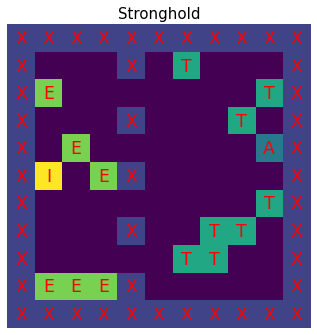

In [57]:
env_size = 11
simplicity = 6 # <- increase this to make environment easier by decreasing enemies and traps
stronghold = Stronghold(env_size, simplicity)
stronghold.reset()
stronghold.render()

In [86]:
# A class to represent policies the agent can take and evaluation of those policies 
class Agent():
    def __init__(self, env, epsilon, lr, episodes, learning_len = 100, discount_factor = 0.999, view=False):
        self.env = env
        self.epsilon = epsilon
        self.lr = lr
        self.episodes = episodes
        self.learning_len = learning_len
        self.discount_factor = discount_factor
        self.action_space = self.env.getActionSpace()
        self.state_space = self.env.getStateSpace()
        print('The number of actions possible are,', self.action_space)
        print('The number of states in the environment are,', self.state_space)
        self.q_table = np.zeros((self.state_space, self.action_space))          # initialising state-action values in q-table to 0 
        self.step_max = 1000
        self.view = view

    def greedy_policy(self, current_state):
        return np.argmax(self.q_table[current_state,:])

    def Qlearn(self):
        total_rewards = []                                      # holds the total rewards for the evaluation of the q-learning
        for batch in range(self.episodes//self.learning_len):   # learning occurs for learning_len number of episodes 
            for learn in range(self.learning_len):
                current_state = self.env.reset()
                for steps in range(self.step_max):
                    if np.random.uniform(0, 1) >= self.epsilon:         #  random choice between exploration (random action) or exploitation (e-greedy policy)
                        choice_action = self.greedy_policy(current_state)
                    else: choice_action = np.random.randint(0, self.action_space - 1)
                    state, reward, done, info = self.env.step(choice_action)
                    # update q_table according to the equation
                    self.q_table[current_state, choice_action] = self.q_table[current_state, choice_action] + self.lr * \
                        (reward + self.discount_factor * self.q_table[state, self.greedy_policy(state)] - self.q_table[current_state, choice_action])   
                    current_state = state
                    if done == True:
                        break 
            avg_reward = self.evaluate_policy(self.greedy_policy, self.episodes, self.view) # run evaluation using greedy policy according to q_table
            total_rewards.append(avg_reward)
        return total_rewards, self.q_table 

    def evaluate_policy(self, policy, episodes, view = False):  # evaluates the greedy policy after exploration/exploitation
        total_evaluation_reward = 0
        for i in range(episodes):
            self.env.reset()
            steps = 0 
            done = False
            state, reward, done, info = self.env.step(policy(self.env.agent_state))
            total_evaluation_reward += (self.discount_factor ** steps) * reward
            episode_rew = (self.discount_factor ** steps) * reward
            steps += 1
            while not done:
                state, reward, done, info = self.env.step(policy(state))
                episode_rew += (self.discount_factor ** steps) * reward
                total_evaluation_reward += (self.discount_factor ** steps) * reward
                steps += 1
                if view == True:
                    print("state", state)
                    self.env.render()
                    time.sleep(0.5)
                    clear_output(wait=True)
        return total_evaluation_reward/episodes

    def plot_evaluation(self, avg_rewards, learning_len, epsilon, lr, discount_factor):
        episodes = []
        for i in range(len(avg_rewards)):
            episodes.append(i * learning_len + 1)

        fig, ax = plt.subplots(figsize=(10,7)); 
        plt.plot(episodes, avg_rewards)
        plt.title('Stronghold Q-learning Avg. Rewards vs. Episodes')
        plt.xlabel("Episodes")
        plt.ylabel("Avg. Reward per {} Episodes".format(learning_len))
        plt.ylim([np.min(avg_rewards)-50, np.max(avg_rewards)+50])
        plt.legend(['Eps={}, Lr={}, Gamma={}'.format(epsilon, lr, discount_factor)], loc='lower right')
        plt.show();

    def plot_policy(self, q_table):
        best_value = np.max(q_table, axis = 1)[:-1].reshape((self.env.size, self.env.size))
        best_action = np.argmax(q_table, axis = 1)[:-1].reshape((self.env.size, self.env.size))
        
        print("Best Policy")
        fig, ax = plt.subplots(figsize=(10,7))
        im = ax.imshow(best_value, cmap ='Set3')

        for i in range(best_value.shape[0]):
            for j in range(best_value.shape[1]):
                if self.env.land[i, j] == 1 or self.env.land[i, j] == 3 or self.env.land[i, j] == 5:
                    sign = self.env.dict_map_display[self.env.land[i,j]]
                elif best_action[i, j] == 0:
                    sign = '^'
                elif best_action[i, j] == 1:
                    sign = 'v'
                elif best_action[i, j] == 2:
                    sign = '<'
                elif best_action[i, j] == 3:
                    sign = '>'
                if i == self.env.starting_pos[0] and j == self.env.starting_pos[1]:
                    sign = 'S ' + sign
                text = ax.text(j, i, sign, ha = "center", va = "center", color = "black", fontsize='x-large')
                
        cbar = ax.figure.colorbar(im, ax = ax, fraction=0.046, pad=0.04)
        fig.tight_layout()
        plt.show(); 

    def print_q_table(self, q_table):
        print("Some Q-table values")
        df = pd.DataFrame(q_table)
        df.columns = ['1', '2', '3', '4']
        print(df[(df > 0).any(1)])

The number of actions possible are, 4
The number of states in the environment are, 122
Time taken for Q-learning is,  257.23570108413696


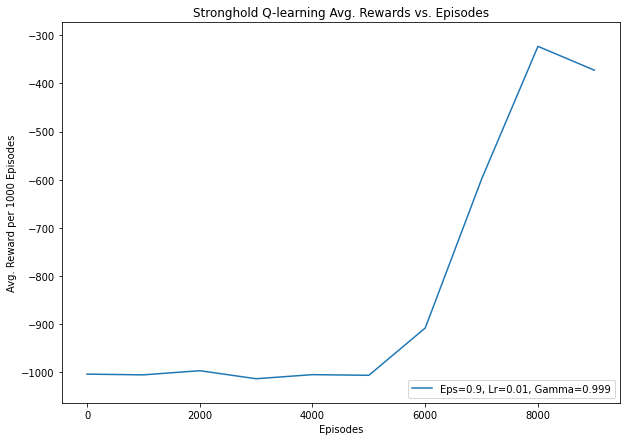

Best Policy


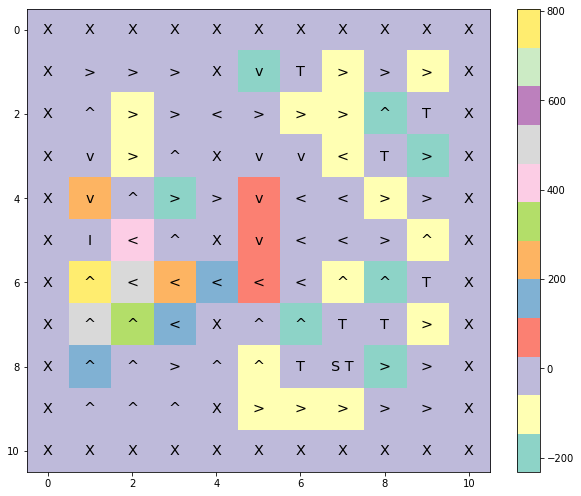

Some Q-table values
             1           2           3          4
34 -397.747922    4.580112  -40.976044 -10.159608
38  -28.313309    6.405805   -8.851400 -17.290217
45   18.639367  216.471957   21.840684   0.000000
49   -0.237543   32.236761  -10.509555 -10.809792
50  -23.389002   -2.522566    2.293582 -14.634451
57 -234.233049   66.809503  380.778744   0.000000
60   25.584605   63.377305   37.609057  -8.292665
61   -4.565419  -10.484831   18.490419 -12.268846
67  804.417797  382.442481  539.907750   0.000000
68  274.504838  223.279238  543.985754   0.000000
69 -678.988889   17.825928  224.422663 -44.623060
70  128.247246  130.196640  163.749862  -8.496525
71   34.741114   13.784590   99.026237 -12.032041
72  -15.788621 -164.395547    6.379635 -36.794715
78  475.729836  164.306993  336.540340   0.000000
79  309.325793   70.770043  230.512530  -0.020792
80   81.427985   -1.570760  146.883638  -0.385525
82   19.580285 -110.728148  -38.888406 -54.842937
89  179.033366 -531.979933  -3

In [91]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.9       # 90% chance of exploration 10% exploration
lr = 0.01           #0.001 is too low
discount = 0.999
episodes = 10000
learning_len = 1000
view = False
plot = True
agent = Agent(stronghold, epsilon, lr, episodes, learning_len=learning_len, discount_factor=discount, view=view)
start = time.time()
avg_eval_rewards, q_table = agent.Qlearn()
print('Time taken for Q-learning is, ', time.time() - start)
if plot:
    agent.plot_evaluation(avg_eval_rewards, learning_len, epsilon, lr, discount)
    agent.plot_policy(q_table)
    agent.print_q_table(q_table)

In [ ]:
stronghold.reset()
## Q-learning parameters
epsilon = 0.2       
lr = 0.01
discount = 0.2
episodes = 5000
learning_len = 1000
view = False
# change epsilon, gamma and lr and plot curves for different combinations on one plot
def changing_lr(epsilon, gamma, lr):
    for i in range(10):
        epsilon += 0.05
        gamma
    pass

def changing_epsilon(epsilon, gamma, lr):
    for i in range(10):
        epsilon += 0.05
        lr += 0.005
    pass

def changing_gamma(epsilon, gamma, lr):
    for i in range(10):
        epsilon += 0.05
        lr += 0.005
    pass